In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query

In [2]:
db = global_connect()

In [3]:
agency = {'1': '6e7dacf2149d053183fe901e3cfd8b82', '2': '58cfe3b975dd7cbd1ac84d555640bfd9'}
from_1, to_1 = '2019-10-02', '2020-03-25'
from_2, to_2 = '2019-10-23', '2020-03-25'

In [4]:
def get_daily_unique_drivers(agency_id, from_, to_):

    return careful_query("""
        SELECT DATE(sent_f) as date,
               COUNT(DISTINCT(driver_id)) as drivers
        FROM availability
        WHERE sent_f >= '{1}' AND sent_f < '{2}'
          AND distribution_center = '{0}'
        GROUP BY DATE(sent_f)
        ORDER BY date""".format(agency_id, from_, to_), 20000000)


In [5]:
df1 = get_daily_unique_drivers(agency['1'], from_1, to_1)

In [6]:
df2 = get_daily_unique_drivers(agency['2'], from_2, to_2)

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     175 non-null    object
 1   drivers  175 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ KB


In [8]:
df1.head()

,date,drivers
0,2019-10-02,1256
1,2019-10-03,1264
2,2019-10-04,1352
3,2019-10-05,561
4,2019-10-06,329


In [9]:
# agency, date, drivers, at_least_once, last_lest_once_in_last_10_days

In [10]:
def get_daily_unique_drivers_alo(agency_id, from_, to_):
    return careful_query("""
        /* Number of available drivers per day of the agency */
        /* Drivers that appears At Least Once in agency itineraries */

        select date(a.sent_f) as date,
               count(distinct(i.driver_id)) as drivers_alo
        from itinerary i
        join availability a
        on i.driver_id = a.driver_id
        where i.distribution_center = '{0}'
          and a.distribution_center = '{0}'
          and a.sent_f >= '{1}'
          and a.sent_f <  '{2}'
        group by i.distribution_center, date(a.sent_f)
        order by date(a.sent_f) asc
        """.format(agency_id, from_, to_), 20000000)    

In [11]:
df1_h = get_daily_unique_drivers_alo(agency['1'], from_1, to_1)

In [12]:
df1.shape == df1_h.shape

True

In [13]:
df2_h = get_daily_unique_drivers_alo(agency['2'], from_2, to_2)

In [14]:
df1.merge(df1_h, on='date').head()

,date,drivers,drivers_alo
0,2019-10-02,1256,484
1,2019-10-03,1264,485
2,2019-10-04,1352,477
3,2019-10-05,561,256
4,2019-10-06,329,168


In [15]:
def get_daily_unique_drivers_alo_10_days(agency_id, from_, to_):
    current = datetime.strptime(from_, '%Y-%m-%d')
    until = datetime.strptime(to_, '%Y-%m-%d')
    
    df = pd.DataFrame()
    while current != until:
        print(str(current)[:10], end=', ')
        next_day = current + timedelta(days=1)
        
        dft = careful_query("""
            /* Number of available drivers per day of the agency */
            /* Drivers that appears At Least Once in agency itineraries */

            select date(a.sent_f) as date,
                   count(distinct(i.driver_id)) as drivers_alo_10_days
            from itinerary i
            join availability a
            on i.driver_id = a.driver_id
            where i.distribution_center = '{0}'
              and a.distribution_center = '{0}'
              and i.finished_time >= (date('{1}') - interval '10 day') -- finished in last 10 days
              and a.sent_f >= '{1}'
              and a.sent_f <  '{2}'
              
            group by i.distribution_center, date(a.sent_f)
            order by date(a.sent_f) asc
            """.format(agency_id, str(current)[:10], str(next_day)[:10]), 2000000)
        
        df = pd.concat([df, dft])
        
        current = next_day
        
    print('')
        
    return df.reset_index(drop = True)
        

In [16]:
df1_h10 = get_daily_unique_drivers_alo_10_days(agency['1'], from_1, to_1)

2019-10-02, 2019-10-03, 2019-10-04, 2019-10-05, 2019-10-06, 2019-10-07, 2019-10-08, 2019-10-09, 2019-10-10, 2019-10-11, 2019-10-12, 2019-10-13, 2019-10-14, 2019-10-15, 2019-10-16, 2019-10-17, 2019-10-18, 2019-10-19, 2019-10-20, 2019-10-21, 2019-10-22, 2019-10-23, 2019-10-24, 2019-10-25, 2019-10-26, 2019-10-27, 2019-10-28, 2019-10-29, 2019-10-30, 2019-10-31, 2019-11-01, 2019-11-02, 2019-11-03, 2019-11-04, 2019-11-05, 2019-11-06, 2019-11-07, 2019-11-08, 2019-11-09, 2019-11-10, 2019-11-11, 2019-11-12, 2019-11-13, 2019-11-14, 2019-11-15, 2019-11-16, 2019-11-17, 2019-11-18, 2019-11-19, 2019-11-20, 2019-11-21, 2019-11-22, 2019-11-23, 2019-11-24, 2019-11-25, 2019-11-26, 2019-11-27, 2019-11-28, 2019-11-29, 2019-11-30, 2019-12-01, 2019-12-02, 2019-12-03, 2019-12-04, 2019-12-05, 2019-12-06, 2019-12-07, 2019-12-08, 2019-12-09, 2019-12-10, 2019-12-11, 2019-12-12, 2019-12-13, 2019-12-14, 2019-12-15, 2019-12-16, 2019-12-17, 2019-12-18, 2019-12-19, 2019-12-20, 2019-12-21, 2019-12-22, 2019-12-23, 2019

In [17]:
df1_h10.shape

(175, 2)

In [18]:
df1.merge(df1_h, on='date').merge(df1_h10, on='date').head(30)

,date,drivers,drivers_alo,drivers_alo_10_days
0,2019-10-02,1256,484,484
1,2019-10-03,1264,485,485
2,2019-10-04,1352,477,477
3,2019-10-05,561,256,256
4,2019-10-06,329,168,168
5,2019-10-07,1188,444,444
6,2019-10-08,1167,430,430
7,2019-10-09,1247,450,450
8,2019-10-10,1357,490,490
9,2019-10-11,1312,481,480


In [19]:
df2_h10 = get_daily_unique_drivers_alo_10_days(agency['2'], from_2, to_2)

2019-10-23, 2019-10-24, 2019-10-25, 2019-10-26, 2019-10-27, 2019-10-28, 2019-10-29, 2019-10-30, 2019-10-31, 2019-11-01, 2019-11-02, 2019-11-03, 2019-11-04, 2019-11-05, 2019-11-06, 2019-11-07, 2019-11-08, 2019-11-09, 2019-11-10, 2019-11-11, 2019-11-12, 2019-11-13, 2019-11-14, 2019-11-15, 2019-11-16, 2019-11-17, 2019-11-18, 2019-11-19, 2019-11-20, 2019-11-21, 2019-11-22, 2019-11-23, 2019-11-24, 2019-11-25, 2019-11-26, 2019-11-27, 2019-11-28, 2019-11-29, 2019-11-30, 2019-12-01, 2019-12-02, 2019-12-03, 2019-12-04, 2019-12-05, 2019-12-06, 2019-12-07, 2019-12-08, 2019-12-09, 2019-12-10, 2019-12-11, 2019-12-12, 2019-12-13, 2019-12-14, 2019-12-15, 2019-12-16, 2019-12-17, 2019-12-18, 2019-12-19, 2019-12-20, 2019-12-21, 2019-12-22, 2019-12-23, 2019-12-24, 2019-12-25, 2019-12-26, 2019-12-27, 2019-12-28, 2019-12-29, 2019-12-30, 2019-12-31, 2020-01-01, 2020-01-02, 2020-01-03, 2020-01-04, 2020-01-05, 2020-01-06, 2020-01-07, 2020-01-08, 2020-01-09, 2020-01-10, 2020-01-11, 2020-01-12, 2020-01-13, 2020

# Create table with unique daily drivers

In [36]:
df_1 = df1.merge(df1_h, on='date').merge(df1_h10, on='date')
df_1 = df_1.set_index('date', drop=True)
df_1['distribution_center'] = agency['1']

In [37]:
df_2 = df2.merge(df2_h, on='date').merge(df2_h10, on='date')
df_2 = df_2.set_index('date', drop=True)
df_2['distribution_center'] = agency['2']

In [38]:
df = pd.concat([df_1, df_2], axis=0)

# Save into DB

In [39]:
df.to_sql('unique_drivers_daily_oozma', con=db) #, if_exists='append')

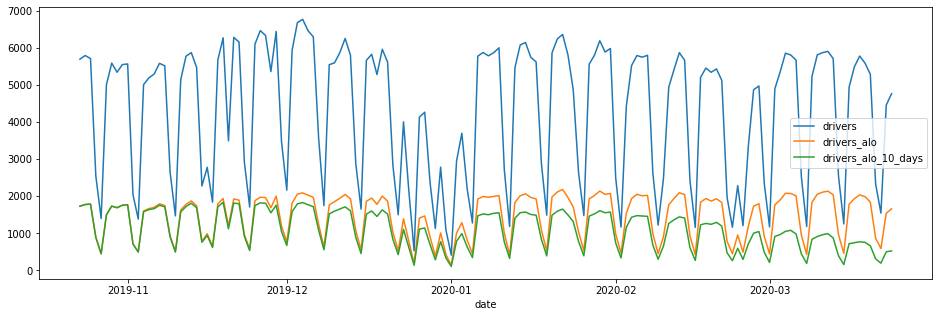

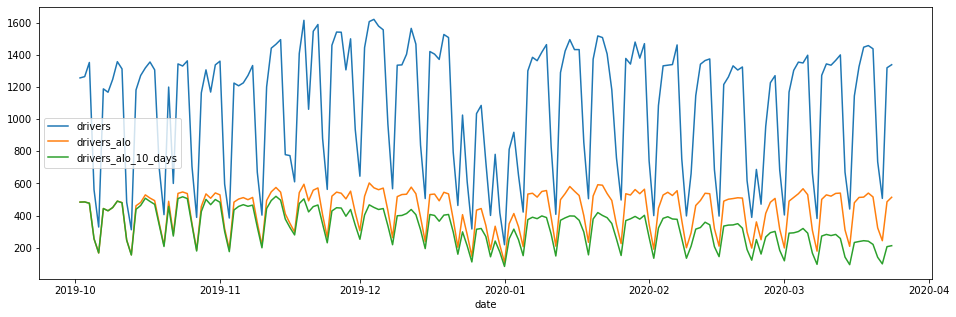

In [40]:
df.groupby('distribution_center').plot(figsize=(16,5));

In [41]:
df.to_csv('unique_drivers_daily_oozma.csv')

In [42]:
df2

,date,drivers
0,2019-10-23,5698
1,2019-10-24,5796
2,2019-10-25,5713
3,2019-10-26,2544
4,2019-10-27,1396
...,...,...
149,2020-03-20,5289
150,2020-03-21,2328
151,2020-03-22,1544
152,2020-03-23,4456
